## KNN (K-nearest neighbors) e uma visão inicial sobre problemas de classificação 

<small>Por: Hugo Soares, Cefas Rodrigues e Arilton Filho</small>

### Visão Geral 

O KNN (K-nearest neighbors, <i> K-vizinhos mais próximos</i>) é um dos mais famosos e simples algoritmos de Machine Learning (ML). Ele é o pontapé inicial da maioria dos entusiastas dessa área, pois além de possuir uma implementação simples, também é bastante intuitivo. Quando utilizado para problemas de classificação, ele tem como objetivo classificar uma amostra de classe desconhecida com base na comparação com outros exemplos rotulados (já classificados). Ou seja, ele implementa um aprendizado baseado em instâncias, <i>Instanced Based Learning</i>. 
    <img src="img/Instance-based-Algorithms.png"> 
    <small>Fonte: https://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/</small>

Como ele compara uma amostra não-rotulada com exemplos classificados (já rotulados), dizemos que ele implementa uma aprendizagem supervisionada. Ou seja, o aprendizado do algoritmo se baseia na supervisão de especialistas que anteriormente classificoram os exemplos que servirão de comparação. Assim, cada registro do meu conjunto de dados possui n atributos e uma classe que o rotula. Já a minha amostra possui apenas os atributos. O conjunto de exemplos que utilizamos para realizar as comparações é chamado de Conjunto de Treino (<i>Training Set</i>), logo cada exemplo é chamado de Instância de Treino (<i>Training Instance</i>) 

<img src="img/supervisioned_learning.png">
<small>Fonte: http://bigdata-madesimple.com/machine-learning-explained-understanding-supervised-unsupervised-and-reinforcement-learning/ </small>

### Dataset do estudo de caso

Por exemplo, em nosso estudo de caso utilizaremos o Haberman's Survival Data Set. Ele é composto por 306 registros de um estudo realizado sobre a sobrevida de pacientes submetidos à cirurgia para câncer de mama. Cada registro possui 3 atributos (idade do paciente na época da operação, ano da operação e o número de nódulos axilares positivos detectados) e uma classe que pode ser 1 ou 2 (1 significa que o paciente sobreviveu por 5 anos ou mais e 2 significa que o paciente morreu dentro de 5 anos). 

<img src="img/haberman.png"> 



### Comparação entre a amostra e as intâncias do conjunto de treino

Já sabemos que o KNN se baseia na comparação de uma amostra de entrada com exemplos já rotulados. Mas como ocorre esse comparação? É nesse ponto que reside a simplicidade do algoritmo. Ele somente compara amostra e um exemplo através da <b>distância euclideana</b> entre eles... 
<br>
<p style="font-size:13px">Relembrando, distância euclidiana é a distância entre dois pontos que é definida através do teorema de pitágoras. A distância euclidiana entre a amostra <i>X</i> e o exemplo <i>Y</i> é mostrada abaixo. Onde X1, X2, ..., Xn são os atributos de X e Y1, Y2, ..., Yn são os atributos Y.</p> 

\begin{align}
d(x, y) = \sqrt{ (x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^2 }
\end{align}

Em seguida ele verifica quais são os K-vizinhos mais próximos da amostra (exemplos com as menores distâncias euclidianas). De acordo com as classes desse vizinhos podemos classificar a amostra. Sendo K=1, verificaremos apenas qual a classe do exemplo mais próximo da entrada e  a indicamos como a possível classe da amostra. Sendo k=3 verificaremos qual a classe que mais se repete nesses 3 vizinhos e a idicamos como classe da amostra. Além disso, podemos indicar essa classe em termos de probabiblidade. Por exemplo, para k=10 se 6 dos vizinhos mais próximos apresentarem a classe A, podemos informar que a amostra tem 60% de chances de pertencer a classe A.  

<img src="img/knn_ilustracao.png"> 
<small>Fonte: https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7</small>

E como podemos analisar a acurácia do nosso algoritmo? Primeiramente dividimos nosso conjunto total de registros rotulados em dois subconjuntos: o conjunto de treino (que já foi explicado) e o conjunto de treino. Em geral, selecionamos randomicamente 70% dos registros para treino e 30% para teste. 
<br><br>
Em seguida, nós aplicamos cada um dos registros de teste ao algoritmo de classificação que construímos e verificamos se a classe gerada pelo algoritmo corresponde a verdadeira classe da instância de teste. Assim, se tivermos 200 exemplos no conjunto de teste e o nosso algoritmo acertar a classe de 190 deles, podemos dizer que sua acurácia é de 95%!  

<img src="img/acuracia.png">

## Vamos Implementar! 

### Preparando nossos dados

Primeiro, importamos nosso dataset de um arquivo externo. Em seguida, o normalizamos, ou seja, deixamos todos os ATRIBUTOS entre 0-1. a coluna da classe permanece igual. Fazemos isso para equilibrar a contribuição de cada atributo no cálculo da distância. Imagine o caso em que o atributo A está no intervalo 0-5 e o atributo B em 0-30000. É fácil perceber que se NÃO houver normalização, possivelmente variações no atributo B terão um impacto muito maior do que variações no atributo A no cálculo da distância entre a amostra e um exemplo qualquer. 

Em seguida, dividimos nosso dataset normalizado em dois subconjuntos: o conjunto de treino e o de teste. Nesse caso, nosso conjunto de treino possui 2/3 do dataset e o restante pertence ao conjunto de treino. 

In [99]:
import numpy as np

def normalizar_dados(dados: object):
    return (dados - np.min(dados, axis=0)) / (np.max(dados, axis=0) - np.min(dados, axis=0))

def processar_dataset(nome_arquivo: str, normalizar: bool=False):
    """
    Importa os dados de um arquivo e divide o dataset 
    em um conjunto de treino e outro de teste
    :param nome_arquivo: nome do arquivo externo
    :normalizar: Indica se os dados devem ser normalizados
    """
    
    dataset = np.loadtxt(nome_arquivo, delimiter=',')
    if normalizar: dataset[:, :3] = normalizar_dados(dataset[:,:3]) #Normalizacao apenas dos atributos

    n = dataset.shape[0] #Quantidade de registros do nosso dataset
    np.random.shuffle(dataset)  #Embaralha o dataset 
    conjunto_de_treino = dataset[(n*8//10):, :] #recebe os elementos com indices > n/3
    conjunto_de_teste = dataset[:(n*8//10), :] #recebe os elementos com indices < n/3
    
    return conjunto_de_treino, conjunto_de_teste


### Vamos encontrar os vizinhos? 

Agora, criamos uma função que recebe uma amostra e procura no conjunto de treino os k-vizinhos mais próximos. 

In [105]:
from scipy.spatial import distance
import operator


def encontrar_vizinhos(conjunto_de_treino: object, amostra: object, k : int=1):
    """
    Recebe uma amostra e encontra os k-vizinhos mais próximos do conjunto
    treino. 
    
    :param amostra: amostra que deve ser comparada com as instancias
        de treino
    :param k: quantidade de vizinhos selecionados
    :return: array com os k-vizinhos e suas distancias  
    """
    distancias = [distance.euclidean(amostra, exemplo) for exemplo in conjunto_de_treino[:, :3]]
    indices_k_vizinhos = np.argsort(distancias)[:k].astype(int)
        
    return [conjunto_de_treino[i] for i in indices_k_vizinhos], sorted(distancias)[:k]

In [101]:
from collections import OrderedDict

def escolher_classe(k_vizinhos: object, k_distancias: object):
    """
    :param kvizinhos: os k vizinhos e suas distancias
    :return: retorna com maior ocorrência nos vizinhos
    """
    
    respostas = {}
    for i, vizinho in enumerate(k_vizinhos):
        resposta = vizinho[-1]
        if resposta in respostas:
            respostas[resposta] +=  1 / (1+k_distancias[i]*2) # voto = 1 / (1 + distancia)
        else:
            respostas[resposta] = 1 / (1 + k_distancias[i]*2) # voto = 1 / (1 + distancia)
            
    respostas = OrderedDict(sorted(respostas.items(), key=operator.itemgetter(1), reverse=True))
    return list(respostas.items())[0][0]


### Juntando tudo... 



Precisão do algoritmo: 72.95 %
Dimensão do conjunto de treino: (62, 4)
Dimensão do conjunto de teste: (244, 4)


<IPython.core.display.Javascript object>


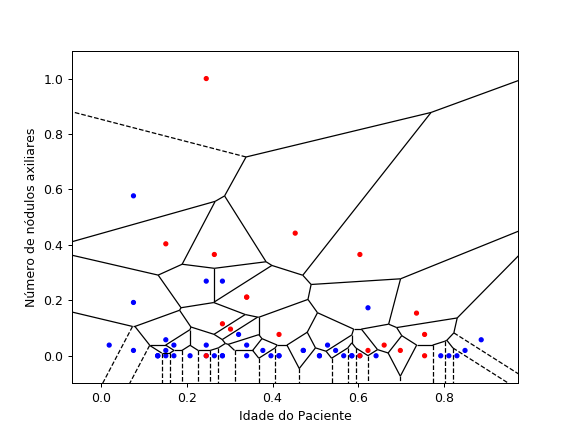

72.95081967213115

In [124]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

def main(mostrar_resultados: bool=True):
    
    conjunto_de_treino, conjunto_de_teste = processar_dataset(nome_arquivo='data/haberman.data', 
                                                             normalizar=True)
    respostas_certas = 0 
    predicoes = [0] * conjunto_de_teste.shape[0]
    
    for (i, amostra) in enumerate(conjunto_de_teste): 
        k_vizinhos, k_distancias = encontrar_vizinhos(conjunto_de_treino=conjunto_de_treino, 
                                        amostra=amostra[:3], k=8)
        predicoes[i] = int(escolher_classe(k_vizinhos, k_distancias))
        if amostra[3] == predicoes[i]: respostas_certas += 1
    
    
    precisao = (respostas_certas/conjunto_de_teste.shape[0])*100
    
    if mostrar_resultados:
        print("Precisão do algoritmo: %.2f %%" %precisao)
        print("Dimensão do conjunto de treino:", conjunto_de_treino.shape)
        print("Dimensão do conjunto de teste:", conjunto_de_teste.shape)
        
        %matplotlib notebook    
        vor = Voronoi(conjunto_de_treino[:, 0:3:2])
        voronoi_plot_2d(vor, show_vertices=0, show_points=0)

        plt.scatter(conjunto_de_treino[:, 0], conjunto_de_treino[:, 2], 
                    c=['red' if i == 2.0 else 'blue' for i in conjunto_de_treino[:, -1]], s=10)

        plt.xlabel('Idade do Paciente')
        plt.ylabel('Número de nódulos axiliares')
        plt.show()
            
    return precisao

main()

### Média e desvio padrão 

Para realmente verificarmos a precisão do algoritmo, deveremos executá-lo várias vezes, calculando a média e o desvio padrão. Além disso, vamos analisar a precisão de acordo com a quantidade de k-vizinhos. 

In [120]:
import time

quantidade_de_testes = 30
lista_de_acuracias = [0] * quantidade_de_testes

for k in range(1, 15):
    print(" ------ k = %d ------" %k)
    
    inicio = time.time()
    for i in range(quantidade_de_testes):
        lista_de_acuracias[i] = main(mostrar_resultados=False) 
    fim = time.time()
    
    print("Acurácia média: %.2f %%" % np.mean(lista_de_acuracias))
    print("Desvio Padrão: %.2f" % np.std(lista_de_acuracias))
    print("Tempo: %.5f s" %(fim-inicio))

 ------ k = 1 ------
Acurácia média: 72.09 %
Desvio Padrão: 3.05
Tempo: 8.67434 s
 ------ k = 2 ------
Acurácia média: 72.17 %
Desvio Padrão: 2.62
Tempo: 8.50911 s
 ------ k = 3 ------
Acurácia média: 72.08 %
Desvio Padrão: 1.98
Tempo: 7.93569 s
 ------ k = 4 ------
Acurácia média: 72.61 %
Desvio Padrão: 2.02
Tempo: 7.98334 s
 ------ k = 5 ------
Acurácia média: 71.64 %
Desvio Padrão: 2.22
Tempo: 7.97184 s
 ------ k = 6 ------
Acurácia média: 72.49 %
Desvio Padrão: 1.78
Tempo: 7.99120 s
 ------ k = 7 ------
Acurácia média: 72.20 %
Desvio Padrão: 1.85
Tempo: 7.97955 s
 ------ k = 8 ------
Acurácia média: 72.09 %
Desvio Padrão: 2.96
Tempo: 7.95399 s
 ------ k = 9 ------
Acurácia média: 71.90 %
Desvio Padrão: 2.36
Tempo: 7.93775 s
 ------ k = 10 ------
Acurácia média: 72.66 %
Desvio Padrão: 1.65
Tempo: 8.14963 s
 ------ k = 11 ------
Acurácia média: 72.36 %
Desvio Padrão: 2.39
Tempo: 8.21347 s
 ------ k = 12 ------
Acurácia média: 71.61 %
Desvio Padrão: 2.60
Tempo: 8.00556 s
 ------ k = 1

### Comparando a implementação da scikit learn

A scikit learn é uma famosa biblioteca que possibilita a utilização de diversos algoritmos de Machine Learning, inclusive o KNN. Vamos testar a implementação do nosso algoritmo com a da scikit. 

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


quantidade_de_testes = 30
lista_de_acuracias = [0] * quantidade_de_testes

print("Resultados do KNN da Scikit Learn: \n")
for k in range(1, 15):
    print(" ------ k = %d ------" %k)
    
    for i in range(quantidade_de_testes):
        conjunto_de_treino, conjunto_de_teste = processar_dataset(nome_arquivo='data/haberman.data', 
                                                             normalizar=True)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(conjunto_de_treino[:, :3], conjunto_de_treino[:, 3])
        predicoes = knn.predict(conjunto_de_teste[:, :3])
        lista_de_acuracias[i] = metrics.accuracy_score(conjunto_de_teste[:, 3], predicoes)*100
            
    print("Acurácia média: %.2f %%" % np.mean(lista_de_acuracias))
    print("Desvio Padrão: %.2f" % np.std(lista_de_acuracias))


Resultados do KNN da Scikit Learn: 

 ------ k = 1 ------
Acurácia média: 65.31 %
Desvio Padrão: 3.11
 ------ k = 2 ------
Acurácia média: 71.42 %
Desvio Padrão: 2.40
 ------ k = 3 ------
Acurácia média: 68.73 %
Desvio Padrão: 3.65
 ------ k = 4 ------
Acurácia média: 72.01 %
Desvio Padrão: 1.69
 ------ k = 5 ------
Acurácia média: 71.49 %
Desvio Padrão: 3.03
 ------ k = 6 ------
Acurácia média: 73.40 %
Desvio Padrão: 1.57
 ------ k = 7 ------
Acurácia média: 72.13 %
Desvio Padrão: 2.58
 ------ k = 8 ------
Acurácia média: 73.50 %
Desvio Padrão: 1.92
 ------ k = 9 ------
Acurácia média: 72.86 %
Desvio Padrão: 1.67
 ------ k = 10 ------
Acurácia média: 73.13 %
Desvio Padrão: 1.17
 ------ k = 11 ------
Acurácia média: 72.66 %
Desvio Padrão: 1.91
 ------ k = 12 ------
Acurácia média: 73.70 %
Desvio Padrão: 1.33
 ------ k = 13 ------
Acurácia média: 72.84 %
Desvio Padrão: 1.97
 ------ k = 14 ------
Acurácia média: 72.72 %
Desvio Padrão: 1.79
